# Animating NFL play tracking data
[View here for better rendered notebook](https://nbviewer.jupyter.org/github/mike-curry00/nfl-big-data-bowl/blob/fb6d6e574363b0b2e5519749350ac1240dcd3da3/Play%20Animation.ipynb)

![SegmentLocal](play_animation.gif "segment")

As part of the inaugural _Big Data Bowl_, the NFL provided some example code for animating player tracking data by using `gganimate` in R. This notebook aims to do the same but with Python (I'm using Python v3.6.7 but I would guess any v3.x.x will do). The data used throughout can be found in the contest's GitHub [repo](https://github.com/nfl-football-ops/Big-Data-Bowl/tree/master/Data) (assuming they haven't already taken it down).

You'll need to have [NumPy](http://www.numpy.org/), [Pandas](https://pandas.pydata.org/), and [Matplotlib](https://matplotlib.org/) (TkAgg backend) installed in order to run the snippets below.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import animation
%matplotlib inline
from textwrap import wrap  # standard library

### Team colors
This [site](https://teamcolorcodes.com/nfl-team-color-codes/) provided a good reference for team hex colors. If a team is away, we'll use the 1st (lighter) color. Otherwise, home teams use the 2nd (darker).

In [2]:
# [light, dark]
TEAM_COLORS = {
    'ARI': ['#97233F', '#000000'],
    'ATL': ['#A71930', '#000000'],
    'BAL': ['#241773', '#000000'],
    'BUF': ['#C60C30', '#00338D'],
    'CAR': ['#0085CA', '#101820'],
    'CHI': ['#C83803', '#0B162A'],
    'CIN': ['#FB4F14', '#000000'],
    'CLE': ['#FF3C00', '#311D00'], 
    'DAL': ['#869397', '#041E42'], 
    'DEN': ['#FB4F14', '#002244'],
    'DET': ['#0076B6', '#B0B7BC'],
    'GB': ['#FFB612', '#203731'],
    'HOU': ['#A71930', '#03202F'],
    'IND': ['#A2AAAD', '#002C5F'],
    'JAX': ['#006778', '#101820'],
    'KC': ['#FFFFFF', '#E31837'],
    'LA': ['#866D4B', '#002244'],
    'LAC': ['#FFC20E', '#002A5E'],
    'MIA': ['#F26A24', '#008E97'],
    'MIN': ['#FFC62F', '#4F2683'],
    'NE': ['#B0B7BC', '#002244'], 
    'NO': ['#D3BC8D', '#101820'],
    'NYG': ['#A5ACAF', '#0B2265'],
    'NYJ': ['#FFFFFF', '#003F2D'],
    'OAK': ['#A5ACAF', '#000000'],
    'PHI': ['#004C54', '#000000'],
    'PIT': ['#FFB612', '#101820'],
    'SEA': ['#69BE28', '#002244'],
    'SF': ['#B3995D', '#AA0000'],
    'TB': ['#B1BABF', '#D50A0A'],
    'TEN': ['#418FDE', '#0C2340'],
    'WAS': ['#FFB612', '#773141']
}

## Drawing the field

The tracking data includes (x,y) coordinates (in yards) for each player and the ball. Let's assume you were gifted some awesome tickets that sit on the 50 yardline. From your vantage point, *x* reflects a player's position on the field from left to right and *y* reflects up and down. 

Field boundaries:
- **x** ranges from 0 to 120 (100 yard field plus 10 yards for each endzone)
- **y** ranges from 0 to 160/3 (53.33)

Note - players can have coordinates outside of those ranges. It just means they're probably out of bounds.

In [3]:
FIELD_WIDTH = 160/3
FIELD_LENGTH = 120

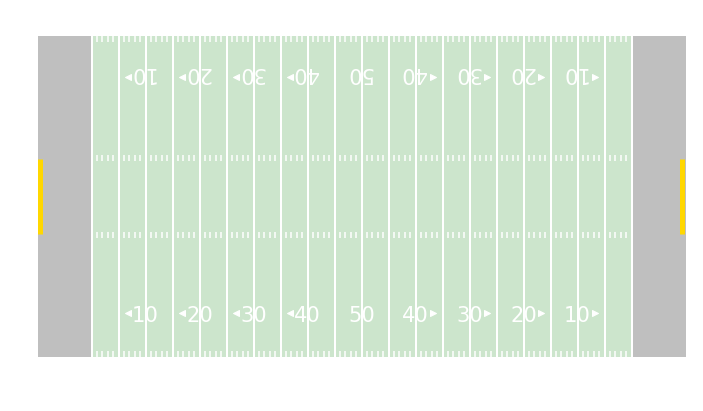

In [4]:
def draw_field():
    
    # set up figure
    fig = plt.figure()
    fig.set_size_inches(12, 7)
    ax = fig.add_subplot(1, 1, 1)
    ax.set(xlim=(-2, FIELD_LENGTH + 2), ylim=(-5, FIELD_WIDTH + 5))
    ax.axis('off')
    
    # rectangles for base field
    left_endzone = plt.Rectangle([0, 0], width=10, height=FIELD_WIDTH, facecolor='gray', alpha=0.5)
    field = plt.Rectangle([10, 0], width=100, height=FIELD_WIDTH, facecolor='green', alpha=0.2)
    right_endzone = plt.Rectangle([110, 0], width=10, height=FIELD_WIDTH, facecolor='gray', alpha=0.5)
    for section in [left_endzone, field, right_endzone]:
        ax.add_patch(section)
    
    # yardlines and 10yd markers
    num_size = 21
    _10yd_marker_adjust = {
        10: 0, 20: .75, 30: .4, 40: .45, 50: .5, 60: .55, 
        70: .5, 80: .45, 90: .4, 100: .75, 110: 0
    } # hack to handle rotation mialignment (definitely more art than science)
    for yd_line in range(10, FIELD_LENGTH - 5, 5):
        ax.vlines(yd_line, 0, FIELD_WIDTH, colors='white', linewidth=2)
        if yd_line % 10 == 0:
            a = _10yd_marker_adjust[yd_line] 
            if 20 <= yd_line <= 60:
                ax.text(s=yd_line-10, x=yd_line, y=7, color='white', 
                        size=num_size, va='center', ha='center')
                ax.text(s=yd_line-10, x=yd_line-a, y=FIELD_WIDTH-6, 
                        color='white', size=num_size, va='center', ha='center', rotation=180)
            elif 70 <= yd_line <= 100:
                ax.text(s=100-(yd_line-10), x=yd_line, y=7, color='white', 
                        size=num_size, va='center', ha='center')
                ax.text(s=100-(yd_line-10), x=yd_line-a, y=FIELD_WIDTH-6, color='white', 
                        size=num_size, va='center', ha='center', rotation=180)
                
    # arrows for 10yd markers
    left_arrow_x_coords = [x - 3.25 for x in (20, 30, 40, 50)]
    left_arrow_y_coords = [7.25] * len(left_arrow_x_coords) + [FIELD_WIDTH-6.75] * len(left_arrow_x_coords)
    right_arrow_x_coords = [x + 3.25 for x in (70, 80, 90, 100)]
    right_arrow_y_coords = [7.25] * len(right_arrow_x_coords) + [FIELD_WIDTH-6.75] * len(right_arrow_x_coords)
    ax.scatter(x=left_arrow_x_coords*2, y=left_arrow_y_coords, marker='<', color='white', zorder=2)
    ax.scatter(x=right_arrow_x_coords*2, y=right_arrow_y_coords, marker='>', color='white', zorder=2)
    
    # hashes
    hash_length, hash_width = 1, 1.5
    mid_hash_upper = FIELD_WIDTH/2 + 20.5/3
    mid_hash_lower = FIELD_WIDTH/2 - 20.5/3
    for yd_line in range(10, FIELD_LENGTH-10, 1):
        ax.vlines(yd_line, 0, hash_length, colors='white', linewidth=hash_width)
        ax.vlines(yd_line, mid_hash_upper-hash_length, mid_hash_upper, colors='white', linewidth=hash_width)
        ax.vlines(yd_line, mid_hash_lower, mid_hash_lower+hash_length, colors='white', linewidth=hash_width)
        ax.vlines(yd_line, FIELD_WIDTH-hash_length, FIELD_WIDTH, colors='white', linewidth=hash_width)
    
    # goal posts
    post_start, post_end = FIELD_WIDTH/2 - 18.5/3, FIELD_WIDTH/2 + 18.5/3
    post_width = 5
    ax.vlines(0.5, post_start, post_end, colors='gold', linewidth=post_width)
    ax.vlines(FIELD_LENGTH-.75, post_start, post_end, colors='gold', linewidth=post_width)
    
    return fig, ax

draw_field();

## Adding Play Info & Layering Initial Player/Ball Positions as Scatterplots

Each play's tracking data is segmented into "frames" that I believe are snapshots of player/ball positions taken every 1/10 of a second. Before we get into animating the play, we'll start by creating a view of all player/ball starting positions (frame.id = 1). Also, we can add attributes of each game/play to the plot such as:

- Scoreboard
- Down and Clock Info
- Location/Weather
- Offensive and Defensive Schemes/Personnel
- First Down Marker (proxy based on starting location of the ball - could get this exactly from the play metadata, though)
- Play Description

Assumption to note:

- Determining the direction of the play is estimated by comparing the average x coordinate of the away team vs the home team.

In [5]:
# Example: Falcons at Bears Week 1
example_game, example_play = 2017091001, 2848

In [6]:
# Supplementary labels

def draw_scoreboard(ax, away_team, home_team, plays_meta):
    away_colors, home_colors = TEAM_COLORS[away_team], TEAM_COLORS[home_team]
    
    # team names
    team_txt_size = 19.5
    ax.text(s=away_team, x=FIELD_LENGTH/2-6, y=FIELD_WIDTH+6, 
            ha='center', va='center', size=team_txt_size, weight='bold',
            color=away_colors[0] if away_colors[0] != '#FFFFFF' else away_colors[1])
    ax.text(s=home_team, x=FIELD_LENGTH/2+6, y=FIELD_WIDTH+6, 
            ha='center', va='center', size=team_txt_size, weight='bold',
            color=home_colors[1] if home_colors[1] != '#FFFFFF' else away_colors[0])
    
    # scores
    score_size = 16.5
    ax.text(s=plays_meta['VisitorScoreBeforePlay'], x=FIELD_LENGTH/2-12, y=FIELD_WIDTH+6, 
            ha='right', va='center', size=score_size, weight='bold')    
    ax.text(s=plays_meta['HomeScoreBeforePlay'], x=FIELD_LENGTH/2+12, y=FIELD_WIDTH+6, 
            ha='left', va='center', size=score_size, weight='bold')
    
    ax.text(s='@', x=FIELD_LENGTH/2, y=FIELD_WIDTH+6, ha='center', va='center', size=11)
    
    # add possession label
    poss_x_coord = FIELD_LENGTH/2 + (-1 if plays_meta['possessionTeam'] == away_team else 1) * 6
    ax.text(s='POSS', x=poss_x_coord, y=FIELD_WIDTH+3.5, ha='center', va='center', 
            size=7, weight='bold', color='white', bbox={'pad': 1, 'facecolor': 'black'})
    

def add_location_and_weather(ax, games_meta):
    location_and_weather = '''
        {stadium}
        {stadium_type} | {turf}
        {weather} | Temp: {temp} | Humidity: {humidity}
        Wind: {wind_speed}mph {wind_direction}
        '''.format(stadium=games_meta['Stadium'], location=games_meta['Location'], 
                   stadium_type=games_meta['StadiumType'], turf=games_meta['Turf'], 
                   weather=games_meta['GameWeather'], temp=games_meta['Temperature'], 
                   humidity=games_meta['Humidity'], wind_speed=games_meta['WindSpeed'], 
                   wind_direction=games_meta['WindDirection'])
    ax.text(s=location_and_weather, x=FIELD_LENGTH, y=FIELD_WIDTH+4, ha='right', va='center', size=9)

    
def add_down_and_clock_info(ax, plays_meta):
    down_txt = {1: '1st', 2: '2nd', 3: '3rd', 4: '4th', 0: '0'}
    play_details = 'Q{qrtr}  {clock}\n{down} & {yds}\n{ydline} yardline'.format(
        qrtr=plays_meta['quarter'], clock=plays_meta['GameClock'][:-3], 
        down=down_txt[plays_meta['down']], yds=plays_meta['yardsToGo'], 
        ydline=int(plays_meta['yardlineNumber'])
    )
    ax.text(s=play_details, x=0, y=FIELD_WIDTH+4, ha='left', va='center', size=9.5)

    
def get_schemes(ax, plays_meta):
    offensive_scheme = 'OFFENSE\n{formation}\n{personnel}'.format(
        formation=plays_meta['offenseFormation'], 
        personnel=plays_meta['personnel.offense']
    )
    
    in_the_box='n/a' if np.isnan(plays_meta['defendersInTheBox']) else int(plays_meta['defendersInTheBox'])
    pass_rushers='n/a' if np.isnan(plays_meta['numberOfPassRushers']) else int(plays_meta['numberOfPassRushers'])
    defensive_scheme = 'DEFENSE\nInTheBox: {inTheBox}\nPassRushers: {passRushers}\n{personnel}'.format(
        inTheBox=in_the_box,
        passRushers=pass_rushers,
        personnel=plays_meta['personnel.defense']
    )
    return offensive_scheme, defensive_scheme

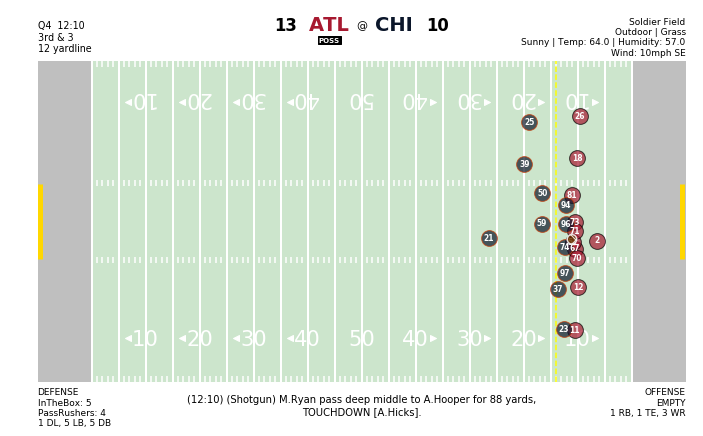

In [7]:
def draw_play_start(game_id, play_id, starting_frame=1, show_static_plot=False):
    games_meta = (pd.read_csv('Data/games.csv')
                    .query(f'gameId == {game_id}')
                    .to_dict(orient='rows')[0])
    plays_meta = (pd.read_csv('Data/plays.csv')
                    .query(f'gameId == {game_id} and playId == {play_id}')
                    .to_dict(orient='rows')[0])
    away_team, home_team  = games_meta['visitorTeamAbbr'], games_meta['homeTeamAbbr']
    plays_meta['awayTeam'], plays_meta['homeTeam'] = away_team, home_team
    
    # get tracking data
    play_tracking = pd.read_csv(f'Data/tracking_gameId_{game_id}.csv').query(f'playId == {play_id}')
    play_tracking.team.replace({'away': away_team, 'home': home_team}, inplace=True)
    
    # get player coordinates for first frame
    is_starting_frame = (play_tracking['frame.id'] == starting_frame)
    away_init = play_tracking[(play_tracking.team == away_team) & 
                              is_starting_frame][['x', 'y', 'jerseyNumber']].values
    home_init = play_tracking[(play_tracking.team == home_team) & 
                              is_starting_frame][['x', 'y', 'jerseyNumber']].values
    ball_init = play_tracking[(play_tracking.team == 'ball') & 
                              is_starting_frame][['x', 'y']].values.flatten()
    
    # draw field
    fig, ax = draw_field()
    
    # add supplementary info
    draw_scoreboard(ax, away_team, home_team, plays_meta)
    add_down_and_clock_info(ax, plays_meta)
    add_location_and_weather(ax, games_meta)
    offensive_scheme, defensive_scheme = get_schemes(ax, plays_meta)
    ax.text(s="\n".join(wrap(plays_meta['playDescription'], width=70)), 
            x=FIELD_LENGTH/2, y=-4, ha='center', va='center')
    
    # first down marker & offense/defense schemes
    scheme_text_size = 9
    if plays_meta['SpecialTeamsPlayType'] not in ['kickoff','Kickoff']:
        if plays_meta['possessionTeam'] == away_team:
            if away_init[:, 0].mean() < home_init[:, 0].mean():
                first_down_proxy = ball_init[0] + plays_meta['yardsToGo']
                left_scheme, right_scheme = offensive_scheme, defensive_scheme
            else:
                first_down_proxy = ball_init[0] - plays_meta['yardsToGo']
                left_scheme, right_scheme = defensive_scheme, offensive_scheme
        else:
            if away_init[:, 0].mean() < home_init[:, 0].mean():
                first_down_proxy = ball_init[0] - plays_meta['yardsToGo']
                left_scheme, right_scheme = defensive_scheme, offensive_scheme
            else:
                first_down_proxy = ball_init[0] + plays_meta['yardsToGo']
                left_scheme, right_scheme = offensive_scheme, defensive_scheme
                
        ax.vlines(first_down_proxy, 0, FIELD_WIDTH, colors='yellow', linewidth=1.5, linestyles='dashed')
        ax.text(s=left_scheme, x=0, y=-1, ha='left', va='top', size=scheme_text_size)
        ax.text(s=right_scheme, x=FIELD_LENGTH, y=-1, ha='right', va='top', size=scheme_text_size)
        
    # players and ball scatterplots
    player_size, ball_size = 250, 90 
    number_color = lambda x: 'white' if x != '#FFFFFF' else 'black'
    away_colors, home_colors = TEAM_COLORS[away_team], TEAM_COLORS[home_team]
    
    away_scatter = ax.scatter(away_init[:, 0], away_init[:, 1], zorder=10, s=player_size, 
                              alpha=0.7, c=away_colors[0], edgecolor=away_colors[1])
    away_numbers = [ax.text(s=int(jerseyNum), x=x, y=y, zorder=20, ha='center', va='center', 
                            size=7.5, weight='bold', color=number_color(away_colors[0])) 
                    for x, y, jerseyNum in away_init]
    home_scatter = ax.scatter(home_init[:, 0], home_init[:, 1], zorder=10, s=player_size, 
                              alpha=0.7, c=home_colors[1], edgecolor=home_colors[0])
    home_numbers = [ax.text(s=int(jerseyNum), x=x, y=y, zorder=20, ha='center', va='center', 
                            size=7.5, weight='bold', color=number_color(home_colors[1])) 
                    for x, y, jerseyNum in home_init]
    ball_scatter = ax.scatter(ball_init[0], ball_init[1], zorder=30, s=ball_size, c='#663300', 
                              edgecolor='white', linewidth=1.5, hatch='x', alpha=0.85)
    
    # placeholder: we'll need this for when we want to show receiver distance/radius from defenders
    openness_circle = plt.Circle((0,0), radius=0.001, alpha=0.3)
    ax.add_patch(openness_circle)
    
    if show_static_plot:
        plt.show()
    
    to_animate = [away_scatter, away_numbers, home_scatter, home_numbers, ball_scatter, openness_circle]
    return fig, play_tracking, plays_meta, to_animate

_ = draw_play_start(example_game, example_play, show_static_plot=True)

## Sidebar: Calculating the most open receiver on the field

For the subset of passing plays, we can determine who on the field is the most open receiver at any point. Here, "most open receiver" is defined as the receiver with the largest Euclidean distance between him and the closest defender:

$$
\begin{equation*}
max \hspace{1mm} \bigl( \hspace{1mm} min \sqrt{(x_r - x_d)^2 + (y_r - y_d)^2} , \hspace{4mm} \forall  d \in Defenders  \hspace{1mm} \bigr), \hspace{4mm} \forall r \in Receivers
\end{equation*}
$$

In [8]:
def get_most_open_receiver_by_frame(play_tracking_df, plays_meta):
    players = pd.read_csv('Data/players.csv')
    play_tracking_df['x,y'] = list(zip(play_tracking_df.x, play_tracking_df.y))
    
    # pull out receivers/defenders
    receiver_ids = players.loc[players.PositionAbbr.isin(['RB','WR','TE']), 'nflId'].values
    receivers = play_tracking_df[(play_tracking_df.nflId.isin(receiver_ids)) & 
                                 (plays_meta['possessionTeam'] == play_tracking_df.team)]
    defenders = play_tracking_df[(plays_meta['possessionTeam'] != play_tracking_df.team) & 
                                 (play_tracking_df.team != 'ball')]
    
    # calc min distance from each receiver from list of defender coordinates
    defender_coords = (defenders.groupby(['playId','frame.id'], as_index=False)[['x,y']]
                                .agg(lambda x: list(x))
                                .rename(columns={'x,y': 'defender_coords'}))
    receivers = pd.merge(receivers, defender_coords, on=['playId','frame.id'])
    get_distance = lambda x: np.linalg.norm(np.array(x['x,y']) - np.array(x['defender_coords']), axis=1).min()
    receivers['open-ness'] = receivers.apply(get_distance, axis=1)
    
    # get most open receiver (max of the mins)
    most_open_receiver = (
        receivers[['x','y','frame.id','open-ness','event','displayName']]
            .sort_values(by=['frame.id','open-ness'], ascending=[1,0])
            .groupby('frame.id', as_index=False).first()
    )
    snap_frame = most_open_receiver.loc[most_open_receiver.event == 'ball_snap', 'frame.id'].values[0]
    most_open_receiver.loc[most_open_receiver['frame.id'] < snap_frame, 'open-ness'] = 0
    return most_open_receiver

## Finally, Animation!

We'll be using `FuncAnimation` from Matplotlib to create the animation, which requires an animate function as an arg. Our function will be written to update the following on each frame:

- Away/Home player scatterplot points
- Away/Home jersey number text objects
- Ball scatterplot points
- Receiver radius circle (updating the position of the center of the circle as well as the size of the radius)

In [9]:
def make_play_animation(game_id, play_id, starting_frame=1):
    
    fig, play_tracking, plays_meta, to_animate = draw_play_start(game_id, play_id)
    [away_scatter, away_numbers, home_scatter, home_numbers, ball_scatter, openness_circle] = to_animate
    if plays_meta['PassResult'] in ['C','I','IN','S','R']:
        most_open_receiver = get_most_open_receiver_by_frame(play_tracking, plays_meta)
    
    def animate(i):
        is_current_frame = (play_tracking['frame.id'] == i+1)
        away_data = play_tracking[(play_tracking.team == plays_meta['awayTeam']) & 
                                  is_current_frame][['x', 'y', 'jerseyNumber']].values
        home_data = play_tracking[(play_tracking.team == plays_meta['homeTeam']) & 
                                  is_current_frame][['x', 'y', 'jerseyNumber']].values
        ball_data = play_tracking[(play_tracking.team == 'ball') & 
                                  is_current_frame][['x', 'y']].values

        away_coords, home_coords = away_data[:, :2], home_data[:, :2]
        away_num_coords = dict(zip(away_data[:, 2].astype(int).tolist(), away_coords.tolist()))
        home_num_coords = dict(zip(home_data[:, 2].astype(int).tolist(), home_coords.tolist()))

        for away_player in away_numbers:
            this_number = int(away_player.get_text())
            away_player.set_position(away_num_coords[this_number])
        for home_player in home_numbers:
            this_number = int(home_player.get_text())
            home_player.set_position(home_num_coords[this_number])

        away_scatter.set_offsets(away_coords)
        home_scatter.set_offsets(home_coords)
        ball_scatter.set_offsets(ball_data)

        update_list = [away_scatter, home_scatter, ball_scatter] + away_numbers + home_numbers
        
        if plays_meta['PassResult'] in ['C','I','IN','S','R']:
            is_frame = most_open_receiver['frame.id'] == i+1
            most_open_receiver_coords = most_open_receiver[is_frame][['x','y','open-ness']].values.flatten()
            openness_circle.center = (most_open_receiver_coords[0], most_open_receiver_coords[1])
            openness_circle.radius = most_open_receiver_coords[2]
            update_list += [openness_circle]
        return update_list
    
    plt.close()
    return animation.FuncAnimation(fig, func=animate, blit=True, interval=75, 
                                   frames=play_tracking['frame.id'].max())


## Rendering the animation

There are two ways to view the animation:

1. Render in the notebook with IPython HTML/JS
2. Save as .gif (I'm running this on Ubuntu 18.04 and used [ImageMagick](https://www.imagemagick.org/) installed)

**Just a heads up**: I've found that these both take a good chunk of time to execute (~10-15 seconds depending on # frames).

In [13]:
# pick a random play
this_game, this_play = pd.read_csv('Data/plays.csv')[['gameId','playId']].sample(1).values.flatten()
animation_result = make_play_animation(this_game, this_play)

### 1. In notebook rendering

In [11]:
from IPython.display import HTML
HTML(animation_result.to_jshtml(fps=10))

### 2. Save as a .gif

In [14]:
animation_result.save('play_animation.gif', writer='imagemagick')